In [ ]:

import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score,precision_score, accuracy_score, recall_score



# **Dataset**

In [ ]:
# Load the movie metadata file. Use '\t' as the separator as it is a tab separated file.
meta_data = pd.read_csv('movie.metadata.tsv', sep='\t', header=None)


FileNotFoundError: ignored

In [ ]:
#Next, we'll load the movie plot dataset into memory.
#The data is stored in a text file, with each row comprising a movie ID and the corresponding plot.
#We'll read it line by line.

movie_plots = []

with open("plot_summaries.txt", 'r') as file:
    plot_reader = csv.reader(file, dialect='excel-tab')
    for data_row in tqdm(plot_reader):
        movie_plots.append(data_row)


42303it [00:01, 23925.83it/s]


In [ ]:
# Separating movie IDs and plots:
ids = []
summaries = []

# extracting movie IDs and plot summaries
for item in tqdm(movie_plots):
    ids.append(item[0])
    summaries.append(item[1])

# creating a dataframe
plot_summary = pd.DataFrame({'movie_id': ids, 'plot': summaries})


100%|██████████| 42303/42303 [00:00<00:00, 905101.85it/s]


In [ ]:
meta_data.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


**NOTE:** No headers are present in the dataset (meta_data). The first column represents the unique movie ID, the third column contains the movie name, and the last column includes the movie genre(s). Other columns will be excluded from this analysis.

In [ ]:
plot_summary.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [ ]:
meta_data.shape


(81741, 9)

In [ ]:
plot_summary.shape

(42303, 2)

# **Data Cleaning**
 Steps:

1. **Column Name Adjustment:**
   - Rename essential columns in the 'movie_metadata' and 'plot_summary' datasets.

2. **Dataframe Fusion:**
   - Combine the 'movie_metadata' and 'plot_summary' datasets into a unified dataframe.

3. **Genre Column Refinement:**
   - Refine the 'genre' column for improved consistency.

4. **Elimination of Rows with No Genre Tags:**
   - Remove rows lacking any genre tags from the dataset.

In [ ]:
#column renaming
meta_data.columns = ["id", 1, "movie_name", 3, 4, 5, 6, 7, "genre"]

In [ ]:
#column renaming
plot_summary.columns = ["id", "summary"]

In [ ]:
#Dataframe integrtion

# change datatype of 'movie_id'
meta_data['id'] = meta_data['id'].astype(str)

merged_df = pd.merge(plot_summary, meta_data[['id', 'movie_name', 'genre']],on='id')

In [ ]:
merged_df.head()

,id,summary,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


In [ ]:
#convert the genre which is in dictionary notion into a Pyhton list
merged_df['genre'][0]



'{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}'

In [ ]:
import json

# Extract values from the 'genre' column at index 0
json.loads(merged_df['genre'][0]).values()



dict_values(['Drama', 'World cinema'])

In [ ]:
# Applying lambda function to extract values from 'genre' column and convert to list
merged_df['genre'] = merged_df['genre'].apply(lambda x: list(json.loads(x).values()))
merged_df.head()

,id,summary,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [ ]:
merged_df.shape

(42204, 4)

In [ ]:
merged_df.head()

,id,summary,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [ ]:
# Filtering out samples with 0 genre tags
filtered_df = merged_df[merged_df['genre'].apply(len) > 0]

# Displaying the shape of the filtered dataset and the original dataset
filtered_df.shape, merged_df.shape


((41793, 4), (42204, 4))

In [ ]:
filtered_df.head()

,id,summary,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


# **Data Visualization : Visualising the different genres**

In [ ]:
#calculate the number of movie genres

# Concatenate all genre lists into a single list
genre_list = sum(merged_df['genre'], [])
unique_genres_count = len(set(sum(merged_df['genre'], [])))
print('Total number of unique genres: {}'.format(unique_genres_count))


Total number of unique genres: 363


In [ ]:
# Creating a frequency distribution of all genres
genre_freq_dist = FreqDist(genre_list)

# Creating a dataframe from the genre frequency distribution
genre_freq_df = pd.DataFrame({'Genre': list(genre_freq_dist.keys()),
                              'Count': list(genre_freq_dist.values())})

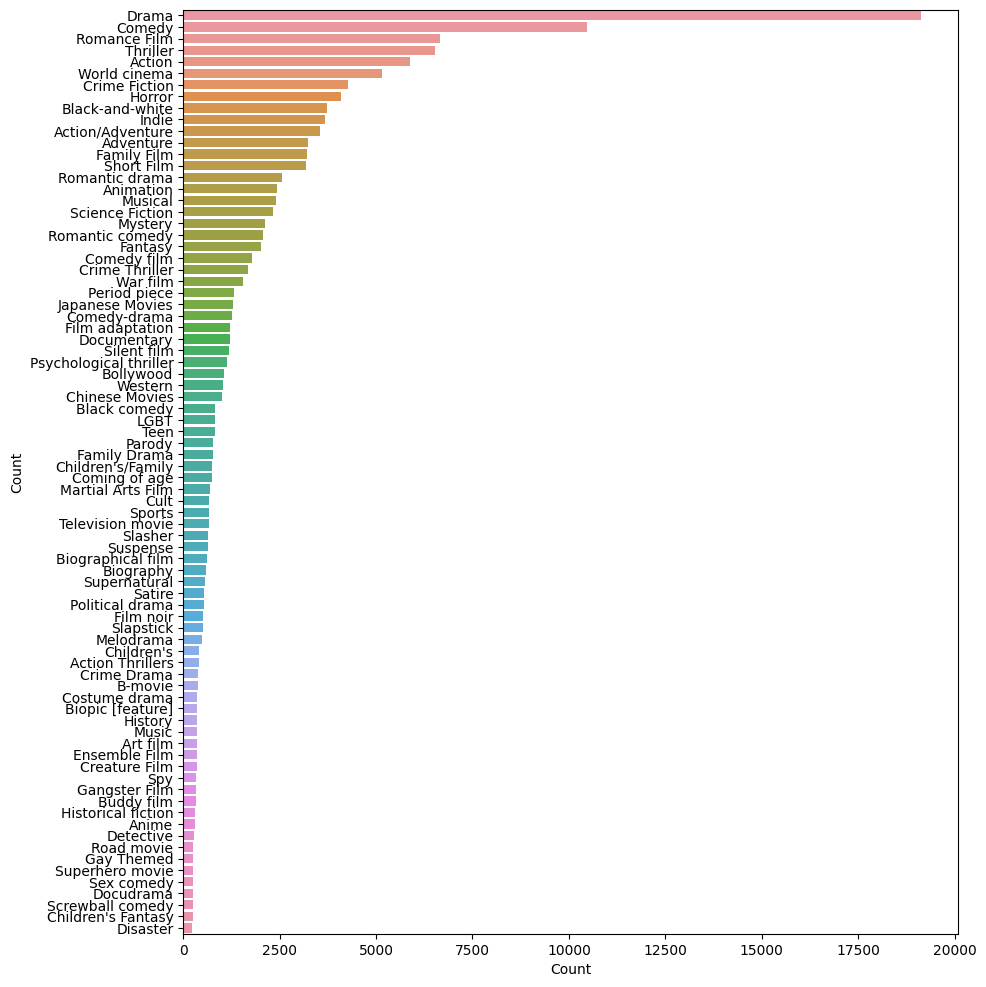

In [ ]:
# Selecting the top 80 genres based on count
top_genres = genre_freq_df.nlargest(columns="Count", n=80)

# Plotting the bar chart
plt.figure(figsize=(10, 12))
ax = sns.barplot(data=top_genres, x="Count", y="Genre")

# Setting y-axis label
ax.set(ylabel='Count')

# Displaying the plot
plt.show()


# **Data Preprocessing**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_plot(summary):
    '''
    Input:
        summary: a string containing a movie plot.
    Output:
        summary_cleaned: a processed movie plot.
    '''

   # Remove links using regular expression
    review = re.sub(r'http\S+', '', summary)

    # Tokenize the summary into words
    words = summary.split()

    # Lowercase all words
    words = [word.lower() for word in words]

    # Remove punctuation and keep only alphanumeric characters
    words = [re.sub(r'[^\w\s]', '', word) for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]


    # Join the cleaned words back into a sentence
    summary_cleaned = ' '.join(words)

    # Apply stemming using Porter Stemmer
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    summary_cleaned = ' '.join(words)

    return summary_cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
filtered_df['clean_summary'] = filtered_df['summary'].apply(lambda x: clean_plot(x))


<ipython-input-129-e7511121a378>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['clean_summary'] = filtered_df['summary'].apply(lambda x: clean_plot(x))


In [ ]:
filtered_df[['summary', 'clean_summary']].head()

,summary,clean_summary
0,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",shlykov hardwork taxi driver lyosha saxophonist develop bizarr loveh relationship despit prejudic realiz arent differ
1,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",nation panem consist wealthi capitol twelv poorer district punish past rebellion district must provid boy girl age 12 18 select lotteri annual hunger game tribut must fight death arena sole survivor reward fame wealth first reap 12yearold primros everdeen chosen district 12 older sister katniss ...
2,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",pooval induchoodan sentenc six year prison life murder classmat induchoodan son justic marancheri karunakara menon frame case manap madhavan nambiar croni dysp sankaranarayanan take reveng idealist judg menon earlier given jail sentenc manap corrupt case induchoodan achiev top rank indian civil ...
3,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",lemon drop kid new york citi swindler illeg tout hors florida racetrack sever success hustl kid come across beauti gullibl woman intend bet lot money kid convinc switch bet employ prefabr con unfortun kid woman belong notori gangster moos moran money kid choic finish dead last furiou moran dem...
4,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",seventhday adventist church pastor michael chamberlain wife lindi two son nineweekold daughter azaria camp holiday outback babi sleep tent famili enjoy barbecu fellow camper cri heard lindi return tent check azaria certain see dingo someth mouth run approach discov infant miss everyon join forc ...


**Converting text to features**

We are going to treat this multi-label classification problem as a Binary Relevance problem

In [ ]:
# Creating an instance of MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()

# Fitting the MultiLabelBinarizer to the 'genre' column in the 'filtered_df' dataframe
multilabel_binarizer.fit(filtered_df['genre'])

# Transforming the target variable 'genre' into binary format
y_binary = multilabel_binarizer.transform(filtered_df['genre'])


In [ ]:
# Splitting the dataset into training and testing sets
X = filtered_df['clean_summary']
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.20, random_state= None)


In [ ]:
#Feature Extraction using TF-IDF Vectorizer from cleaned movie summary

# Creating a TF-IDF vectorizer with specified parameters
tfidf = TfidfVectorizer(max_df=0.8, max_features=10000)

# Fit Transforming the training data using the TF-IDF vectorizer
X_train_tfidf = tfidf.fit_transform(X_train)

# Transforming the test data using the same TF-IDF vectorizer
X_test_tfidf = tfidf.transform(X_test)




# **Building the Model**

In [ ]:
# Initializing a Logistic Regression model
logistic_reg_model = LogisticRegression()

# Creating a One-vs-Rest Classifier using Logistic Regression as the base estimator
one_vs_rest_classifier = OneVsRestClassifier(logistic_reg_model)


In [ ]:
# Fitting the classifier on the training data
one_vs_rest_classifier.fit(X_train_tfidf, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 36 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 245 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 259 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 351 is present in all training examples.
  warnings.warn(


OneVsRestClassifier(estimator=LogisticRegression())

# **Model Prediction**

In [ ]:
# Making predictions for the validation set using the trained classifier
y_prediction = one_vs_rest_classifier.predict(X_test_tfidf)
print(y_prediction[70])

[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
multilabel_binarizer.inverse_transform(y_prediction)[70]


('Action', 'Action/Adventure', 'Thriller')

In [ ]:
# A function to predict the the movie genres
def predict_genre_tags(plot):
    plot = clean_plot(plot)
    plot_vec = tfidf.transform([plot])
    plot_pred = one_vs_rest_classifier.predict(plot_vec)
    return multilabel_binarizer.inverse_transform(plot_pred)

In [ ]:
# Prediction 1
movie_name = 'Mission: Impossible - Fallout(2018))'
plot_summary = "Ethan Hunt and the IMF team join forces with CIA assassin August Walker to prevent a disaster of epic proportions. Arms dealer John Lark and a group of terrorists known as the Apostles plan to use three plutonium cores for a simultaneous nuclear attack on the Vatican, Jerusalem and Mecca, Saudi Arabia. When the weapons go missing, Ethan and his crew find themselves in a desperate race against time to prevent them from falling into the wrong hands."
actual_genre = ['Action', 'Thriller', 'Adventure']
predicted_genre = predict_genre_tags(plot_summary)
print('Movie: {}\nPredicted genres: {}\nActual genres: {}'.format(movie_name, predicted_genre[0], actual_genre))

Movie: Mission: Impossible - Fallout(2018))
Predicted genres: ('Action', 'Action/Adventure', 'Thriller')
Actual genres: ['Action', 'Thriller', 'Adventure']


In [ ]:
# Prediction 2
movie_name = 'The Notebook (2004)'
plot = "In 1940s South Carolina, mill worker Noah Calhoun (Ryan Gosling) and rich girl Allie (Rachel McAdams) are desperately in love. But her parents don't approve. When Noah goes off to serve in World War II, it seems to mark the end of their love affair. In the interim, Allie becomes involved with another man (James Marsden). But when Noah returns to their small town years later, on the cusp of Allie's marriage, it soon becomes clear that their romance is anything but over."
actual_genre = ['Romance', 'Comedy', 'Drama']
predicted_genre = predict_genre_tags(plot)
print('Movie: {}\nPredicted genres: {}\nActual genres: {}'.format(movie_name, predicted_genre[0], actual_genre))

Movie: The Notebook (2004)
Predicted genres: ('Drama', 'Romance Film')
Actual genres: ['Romance', 'Comedy', 'Drama']


# **Model Evaluation**

In [ ]:
# Calculating precision
precision = precision_score(y_test, y_prediction, average='micro')

# Displaying the precision
print('Precision: {:.4f}'.format(precision))


NameError: ignored

In [ ]:
print(f1_score(y_test, y_prediction, average="micro"))

0.3188279365731


In [ ]:
# Adjusting the probability threshold from 0.5 to 0.2
y_pred_probabilities = one_vs_rest_classifier.predict_proba(X_test_tfidf)
y_pred_adjusted = (y_pred_probabilities >= 0.1).astype(int)




In [ ]:
# Calculating the F1 score with the adjusted predictions
f1_score = f1_score(y_test, y_pred_adjusted, average="micro")
print(f1_score)

0.4341527299699825


In [ ]:
# Calculating precision
precision = precision_score(y_test, y_prediction, average='micro')

recall = recall_score(y_test, y_prediction, average=None)

# Displaying the precision
print('Precision: {:.4f}'.format(precision))


Precision: 0.7041
Accuracy: 0.07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_test is the true labels for the testing set and y_prediction is the model predictions
# Convert multilabel indicators to a flat format
y_test_flat = y_test.argmax(axis=1)
y_pred_flat = y_prediction.argmax(axis=1)

# Calculate confusion matrix
conf_matrix = multilabel_confusion_matrix(y_test_flat, y_pred_flat)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[[6025 2320]
  [  10    4]]

 [[8358    0]
  [   1    0]]

 [[7018  169]
  [ 884  288]]

 [[8355    0]
  [   4    0]]

 [[8167   11]
  [ 176    5]]

 [[8348    0]
  [  11    0]]

 [[8334    0]
  [  25    0]]

 [[7945   51]
  [ 323   40]]

 [[8356    0]
  [   3    0]]

 [[8357    0]
  [   2    0]]

 [[8358    0]
  [   1    0]]

 [[8339    0]
  [  20    0]]

 [[8348    0]
  [  11    0]]

 [[8347    0]
  [  12    0]]

 [[8357    0]
  [   2    0]]

 [[8356    0]
  [   3    0]]

 [[8344    0]
  [  15    0]]

 [[7964   46]
  [ 220  129]]

 [[8353    0]
  [   6    0]]

 [[8357    0]
  [   2    0]]

 [[8358    0]
  [   1    0]]

 [[8354    0]
  [   5    0]]

 [[8357    0]
  [   2    0]]

 [[8293    0]
  [  66    0]]

 [[8357    0]
  [   2    0]]

 [[8343    0]
  [  16    0]]

 [[8358    0]
  [   1    0]]

 [[8296    0]
  [  63    0]]

 [[8355    0]
  [   4    0]]

 [[8357    0]
  [   2    0]]

 [[8355    0]
  [   4    0]]

 [[8358    0]
  [   1    0]]

 [[8356    0]
  [   3 

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00         1
           2       0.63      0.25      0.35      1173
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        96
           5       0.59      0.10      0.17       727
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        26
           8       0.73      0.13      0.22       686
           9       0.00      0.00      0.00        23
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        30
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        30
          16       0.00      0.00      0.00         2
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
